<a href="https://colab.research.google.com/github/jindalsparsh/Job-Description-Generator-Lang-Graph/blob/main/Langgraph_Job_Description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_openai langchain_community google-search-results

In [3]:
import os
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import OpenAI

In [4]:
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TALIVY_API_KEY')

In [5]:
class State(TypedDict):
    firm_name: str
    role: str
    search_results: list
    job_description: str

In [6]:
graph_builder = StateGraph(State)

In [7]:
def input_node(state: State):
    firm = state.get("firm_name")
    role = state.get("role")
    if not firm or not role:
        raise ValueError("Firm name and role must be provided.")
    return state  # Passes the input forward without changes

graph_builder.add_node("input", input_node)

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Initialize the Tavily search tool
tavily_search = TavilySearchResults(max_results=2, api_key=os.getenv("TAVILY_API_KEY"))

def search_node(state: State):
    firm = state["firm_name"]
    role = state["role"]

    # Search for firm information
    firm_info = tavily_search.invoke(f"About {firm}")

    # Search for role information
    role_info = tavily_search.invoke(f"Responsibilities of a {role}")

    return {
        "search_results": [firm_info, role_info]
    }

graph_builder.add_node("search", search_node)


In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def job_description_node(state: State):
    firm = state["firm_name"]
    role = state["role"]
    search_results = state["search_results"]

    firm_info = search_results[0]
    role_info = search_results[1]

    prompt = f"""
    Create a comprehensive job description for the role of {role} at {firm}.
    Here is some information about the firm:
    {firm_info}

    And here are the responsibilities of the role:
    {role_info}

    Based on this information, generate a detailed job description that includes:
    - Job Title
    - Company Overview
    - Responsibilities
    - Qualifications
    - Benefits
    """

    job_desc = llm.invoke(prompt)

    return {
        "job_description": job_desc
    }

graph_builder.add_node("generate_job_description", job_description_node)

In [10]:
# Connect START to Input
graph_builder.add_edge(START, "input")

# Connect Input to Search
graph_builder.add_edge("input", "search")

# Connect Search to Job Description
graph_builder.add_edge("search", "generate_job_description")

# Connect Job Description to END
graph_builder.add_edge("generate_job_description", END)

In [11]:
graph = graph_builder.compile()

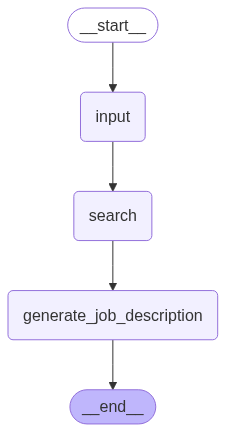

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
user_input = {
        "firm_name": "Accenture ",
        "role": "Sales manager",
        "search_results": [],
        "job_description": ""
    }

In [18]:
result = graph.invoke(user_input)

In [19]:
print(result['job_description'].content)

**Job Title:** Sales Manager

**Company Overview:**
Accenture is a global professional services company with leading capabilities in digital, cloud, and security. Combining unmatched experience and specialized skills across more than 40 industries, we offer strategy and consulting, digital transformation, technology implementation, and operations services. We are committed to driving innovation and delivering value to our clients, enabling them to achieve high performance and create new growth opportunities in a rapidly changing business landscape.

**Responsibilities:**
As a Sales Manager at Accenture, you will play a critical role in driving our sales strategy and achieving business growth. Your responsibilities will include:

1. **Sales Strategy Development:**
   - Develop and execute comprehensive sales strategies to meet or exceed revenue targets.
   - Analyze market trends and customer needs to identify growth opportunities.

2. **Client Relationship Management:**
   - Build and 